In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

from matplotlib.patches import Rectangle
from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy

In [2]:
DIRECTORY = "/kaggle/input/custom-lfw/Augmented_LFW_final/Augmented_LFW_Final"

(250, 250, 3, 3)


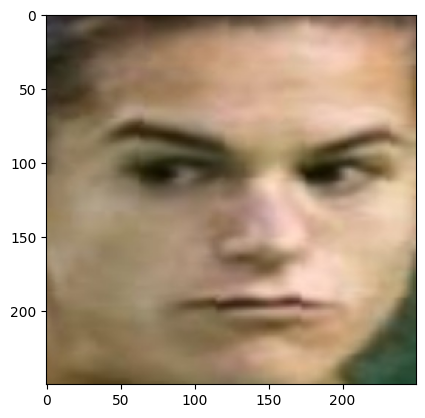

In [3]:
filename = "/kaggle/input/custom-lfw/Augmented_LFW_final/Augmented_LFW_Final/Amelie_Mauresmo/1.jpg"
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(pixels)
plt.show()

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-04-26 19:00:48.567242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 19:00:48.567325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 19:00:48.568962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def load_dataset(directory):
    images = []
    labels = []
    for subdir in os.listdir(directory):
        # Path to subfolder
        folder_path = os.path.join(directory, subdir)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                # Skip non-image files
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, file)
                    img = load_img(img_path, target_size=(64, 64))
                    img = img_to_array(img)
                    img /= 255.0  # Normalize to [0, 1]
                    images.append(img)
                    labels.append(subdir)  # Subfolder name as label

    return np.array(images), np.array(labels)

# Base directory containing subfolders with images
base_dir = DIRECTORY
images, labels = load_dataset(base_dir)

In [6]:
print(images.shape)
print(labels.shape)

(3408, 64, 64, 3)
(3408,)


In [7]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [8]:
encoded_labels

array([29, 29, 29, ...,  2,  2,  2])

In [9]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

print(f'Training samples: {x_train.shape[0]}, Validation samples: {x_val.shape[0]}')

Training samples: 2726, Validation samples: 682


CNN

In [10]:

def plot_accuracy_graph(accuracy):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 25), accuracy, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
    plt.ylim(50, 100)
    plt.title('Accuracy for each K Value')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy %')


In [11]:
x_train_flattened = x_train.reshape(len(x_train), -1)
x_val_flattened = x_val.reshape(len(x_val), -1)



In [12]:
x_train_flattened.shape

(2726, 12288)

In [13]:
x_val_flattened.shape

(682, 12288)

In [14]:
y_train

array([ 1, 28,  7, ...,  6, 20, 15])

In [15]:
dim = 12288

In [16]:
def compute_classes_mean_matrix(train_data, train_labels):
    means = np.zeros((50, dim))
    train_test_split_ratio = 5

    for i in range(0, 50):
        temp = np.where(train_labels == i)[0]

        # Check if temp is empty
        if len(temp) == 0:
            print("Warning: No samples found for class", i)
            continue

        temp_sum = np.zeros((1, dim))
        for j in range(min(train_test_split_ratio, len(temp))):  # Ensure not to exceed the length of temp
            temp_sum += train_data[temp[j], :]

        means[i - 1, :] = temp_sum / min(train_test_split_ratio, len(temp))
    return means

In [17]:
def compute_overall_mean_matrix(classes_means):
    temp_sum = np.zeros((1,dim))
    for i in range(0,50):
        temp_sum +=classes_means[i,:]
    overall_mean = temp_sum / 50

    return overall_mean.T

In [18]:
#the matrix of the overall scatter between all the 50 classes
def compute_between_class_scatter_matrix(classes_means,overall_mean):
    n=5
    Sb = np.zeros((classes_means.shape[1],classes_means.shape[1]))
    for i in range(classes_means.shape[0]):
        Sb = np.add(Sb,n* ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))
    return Sb

In [19]:
def compute_center_class_matrix(train_data,train_labels,classes_means):
    Z = np.zeros(train_data.shape)

    for i in range(train_data.shape[0]):
        Z[i,:] = train_data[i,:] - classes_means[int(train_labels[i])-1,:]

    return Z

In [20]:
def compute_class_scatter_matrix(Z):
    S = np.zeros((dim,dim))
    S = np.dot(Z.T,Z)
    return S

In [21]:
x_train.shape


(2726, 64, 64, 3)

In [22]:
x_val.shape

(682, 64, 64, 3)

In [23]:
def data_dimencionality_reduction(train_data,test_data):
    train_data_dimensionally_reductuted = np.zeros((2726,50))
    test_data_dimensionally_reductuted = np.zeros((682,50))

    i=0
    for img in train_data:
        train_data_dimensionally_reductuted[i,:]=np.dot(img,eigen_vectors)
        i+=1
    i=0
    for img in test_data:
        test_data_dimensionally_reductuted[i,:] = np.dot(img,eigen_vectors)
        i+=1

    return train_data_dimensionally_reductuted,test_data_dimensionally_reductuted


In [24]:
print('Done Train Test Split')
print('-----------------------------------------------------------')

classes_means = compute_classes_mean_matrix(x_train_flattened,y_train)
print('Done classes means computing')
print('-----------------------------------------------------------')

Done Train Test Split
-----------------------------------------------------------
Done classes means computing
-----------------------------------------------------------


In [25]:
overall_mean = compute_overall_mean_matrix(classes_means)
print('Done overall mean computing')
print('-----------------------------------------------------------')

Done overall mean computing
-----------------------------------------------------------


In [26]:
S_between = compute_between_class_scatter_matrix(classes_means,overall_mean)
print('Done between class scater matrix computing')
print('-----------------------------------------------------------')

Done between class scater matrix computing
-----------------------------------------------------------


In [27]:
Z = compute_center_class_matrix(x_train_flattened,y_train,classes_means)
print('Done center class scatter matrix computing')
print('-----------------------------------------------------------')

Done center class scatter matrix computing
-----------------------------------------------------------


In [28]:
S_classes = compute_class_scatter_matrix(Z)
print('Done within class scatter matrix computing')
print('-----------------------------------------------------------')

Done within class scatter matrix computing
-----------------------------------------------------------


In [29]:
W_value = np.dot(np.linalg.inv(S_classes),S_between)
print('Done W = S^(-1)B  computing')
print('-----------------------------------------------------------')

Done W = S^(-1)B  computing
-----------------------------------------------------------


In [30]:
#50 largest eigen values
eigen_values,eigen_vectors = scipy.linalg.eigh(W_value,eigvals=((dim-50),(dim-1)))
print('Done eigen values and vectors computing')
print('-----------------------------------------------------------')

/tmp/ipykernel_219/1099497260.py:2: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigen_values,eigen_vectors = scipy.linalg.eigh(W_value,eigvals=((dim-50),(dim-1)))


Done eigen values and vectors computing
-----------------------------------------------------------


In [36]:
train_data_dimensionally_reductuted,test_data_dimensionally_reductuted = data_dimencionality_reduction(x_train_flattened,x_val_flattened)

In [37]:
from sklearn.neighbors import KNeighborsClassifier

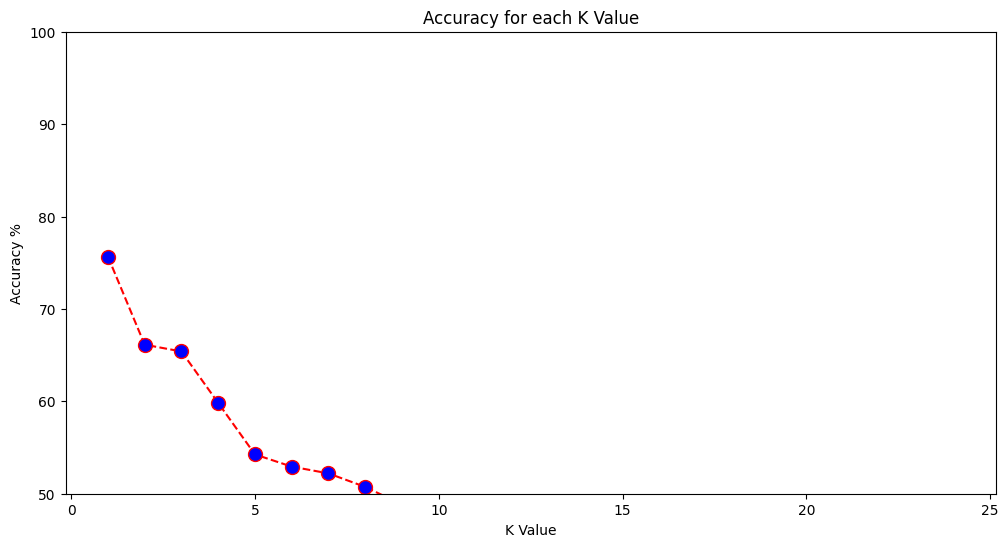

In [38]:
accuracy = []
#Apply KNN
for i in range(1, 25):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(train_data_dimensionally_reductuted, y_train)

    test_predict = classifier.predict(test_data_dimensionally_reductuted)

    true_predicted_count=0
    for j in range(0,682):
        if test_predict[j] ==y_val[j]:
            true_predicted_count+=1
    accuracy.append((true_predicted_count/682)*100)

#plot graph for different K values
plot_accuracy_graph(accuracy) 

In [39]:
print(accuracy)

[75.65982404692082, 66.12903225806451, 65.39589442815249, 59.82404692082112, 54.252199413489734, 52.93255131964809, 52.19941348973607, 50.733137829912025, 48.82697947214076, 46.774193548387096, 45.74780058651026, 45.60117302052786, 43.988269794721404, 43.6950146627566, 42.52199413489736, 42.961876832844574, 42.375366568914956, 41.05571847507331, 40.17595307917888, 40.029325513196476, 40.029325513196476, 40.17595307917888, 40.469208211143695, 39.29618768328446]


In [40]:
accuracy = []
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(train_data_dimensionally_reductuted, y_train)

test_predict = classifier.predict(test_data_dimensionally_reductuted)

true_predicted_count=0
for j in range(0,682):
    if test_predict[j] ==y_val[j]:
        true_predicted_count+=1
accuracy.append((true_predicted_count/682)*100)

In [41]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score




# Calculate metrics
accuracy = accuracy_score(y_val, test_predict)
report = classification_report(y_val, test_predict, target_names=encoder.classes_)

accuracy_percentage = accuracy * 100

# Overall precision, recall, f1-score
overall_precision = precision_score(y_val, test_predict, average='weighted')
overall_recall = recall_score(y_val, test_predict, average='weighted')
overall_f1 = f1_score(y_val, test_predict, average='weighted')

print(f'Overall Accuracy: {accuracy_percentage:.3f}%')
print(f'Overall Precision: {overall_precision:.3f}')
print(f'Overall Recall: {overall_recall:.3f}')
print(f'Overall F1-Score: {overall_f1:.3f}')

print(report)

Overall Accuracy: 75.660%
Overall Precision: 0.783
Overall Recall: 0.757
Overall F1-Score: 0.762
                        precision    recall  f1-score   support

       Amelie_Mauresmo       0.92      0.69      0.79        16
          Andre_Agassi       0.80      0.92      0.86        13
          Andy_Roddick       0.64      0.88      0.74         8
       Anna_Kournikova       0.71      0.83      0.77        12
         Ari_Fleischer       0.80      0.75      0.77        16
  Atal_Bihari_Vajpayee       1.00      0.71      0.83        14
          Bill_Clinton       0.59      0.62      0.61        16
        Britney_Spears       0.70      0.70      0.70        20
           Dick_Cheney       0.81      0.72      0.76        18
 Dominique_de_Villepin       0.81      0.72      0.76        18
          Fidel_Castro       0.79      0.73      0.76        15
           Halle_Berry       1.00      0.88      0.93         8
             Hans_Blix       1.00      0.77      0.87        13
      

In [42]:
test_predict

array([29,  2, 40,  9, 32, 20, 31,  7, 18, 26, 37,  7, 21, 44, 32, 42,  5,
       30, 17,  8, 20, 15, 22, 10,  1, 29, 17, 45,  4, 44, 44, 20, 10, 12,
       23, 38, 35,  7, 11, 29, 24, 26,  2,  4, 41, 22,  6, 28,  6,  9, 19,
       32, 49,  5, 17, 35, 21, 27,  0, 16, 14, 42, 39, 12,  8, 19, 29,  0,
        1,  2, 29, 15, 39,  3, 32, 19, 34, 42,  9, 24, 43, 10, 48, 12, 29,
        5, 22, 27, 30, 34, 43, 39,  5, 21,  6, 21, 46, 19, 27,  5,  1, 29,
       36, 31,  5, 25, 37, 39, 20, 46, 43, 47, 25, 45, 49, 29, 42, 15, 10,
        7, 26,  8, 42, 42, 44,  7, 22, 10, 29, 46, 29, 24, 41, 11, 18, 14,
       21, 25,  0,  6, 23, 31, 11,  8, 43, 13, 13, 43, 17, 47, 45,  3, 40,
       20, 40, 26, 36, 13, 26,  4, 18, 34, 45, 42, 41, 30,  2, 19,  6, 24,
       26, 46, 17, 16, 40, 47, 37, 38, 23, 24, 24, 44,  5, 43, 14, 44,  6,
       24, 10,  7, 32, 45, 21,  3, 27, 24, 37, 45,  1, 35, 12, 24, 49, 44,
       10, 14,  4, 13, 45, 49, 46, 29, 44, 40,  1, 22, 45, 28,  7,  0, 25,
       23, 12, 44, 24, 46

In [43]:
y_val

array([29,  2, 34,  9, 32, 20, 31,  7, 22, 26, 37,  7, 23, 35, 32, 42,  5,
       30, 17, 12, 20, 15, 49, 10,  1, 29, 17, 45, 23, 44, 44, 20, 10, 12,
       23,  6, 34,  7, 11, 42, 24, 26,  2,  4, 41, 16,  6, 36,  6,  9, 19,
       32, 49,  5, 17, 35,  4, 27,  0,  8, 14, 42, 39, 12,  8, 19, 19,  0,
       42, 25, 29, 15, 40,  3, 32, 19, 34, 42,  9, 24, 43, 10, 48, 12, 29,
        5, 22, 27, 30, 34, 43, 34,  5, 21,  6, 21, 46, 19, 27,  5,  1, 29,
       36, 31,  5, 25, 37, 39, 20, 46, 43, 47,  3, 45, 49, 29, 42, 15, 10,
        7, 26,  8, 42, 42, 44,  9,  7, 10, 31, 46, 13, 24, 41, 11,  5, 13,
       21, 25,  0, 10, 23, 31, 11, 21, 43, 13, 13, 43, 17, 47, 45, 32, 40,
       20, 40, 26, 11, 13, 26,  4,  8, 42, 45, 40, 41, 35,  2,  0, 37, 24,
       26, 46, 17, 16, 40, 23, 16, 38, 23, 17, 24, 32,  5, 43, 44, 44,  6,
       24, 10,  5, 32, 45, 21,  3, 27, 24, 37, 45, 15, 35, 12, 24, 49, 20,
       10, 14,  4, 25, 28, 49, 46, 18, 44, 13,  1, 22, 45, 28,  7,  0, 25,
        6, 12, 34, 24, 46